In [65]:
using Images, ImageFiltering, FileIO, ImageView, ImageMorphology, ColorTypes, ImageDraw, Colors

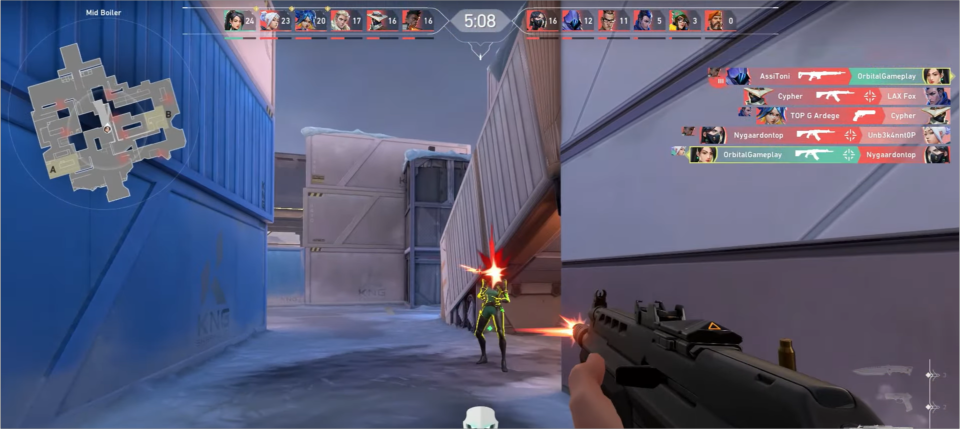

In [66]:
img = load("cap2.png")

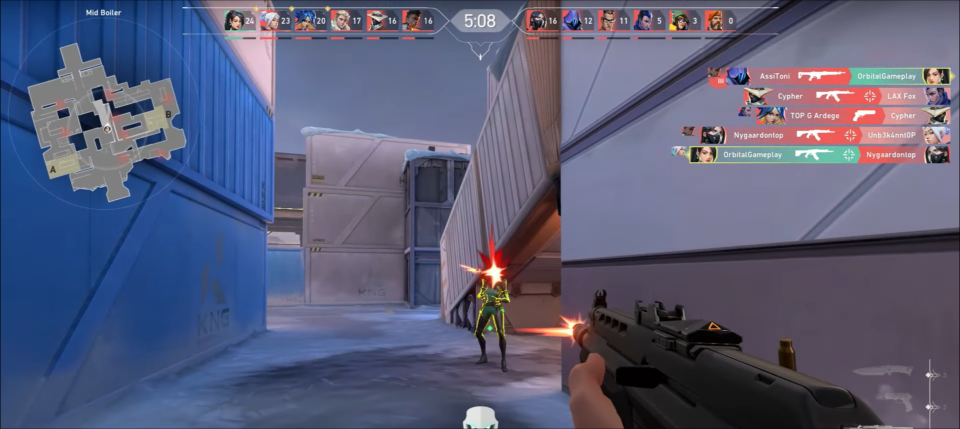

In [67]:
img_hsv = HSV.(img)

In [68]:
# Define the yellow color range in HSV, ensuring the type matches img_hsv pixels
yellow_low = HSV{Float32}(40, 100/255, 155/255)


In [69]:
yellow_high = HSV{Float32}(71, 255/255, 255/255)

In [70]:
mask = map(img_hsv) do pixel
    h, s, v = pixel.h, pixel.s, pixel.v
    h_low, s_low, v_low = yellow_low.h, yellow_low.s, yellow_low.v
    h_high, s_high, v_high = yellow_high.h, yellow_high.s, yellow_high.v

    h_in_range = h_low <= h <= h_high
    s_in_range = s_low <= s <= s_high
    v_in_range = v_low <= v <= v_high

    return h_in_range && s_in_range && v_in_range ? 1 : 0
end

857×1918 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱              ⋮              ⋮     
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0   

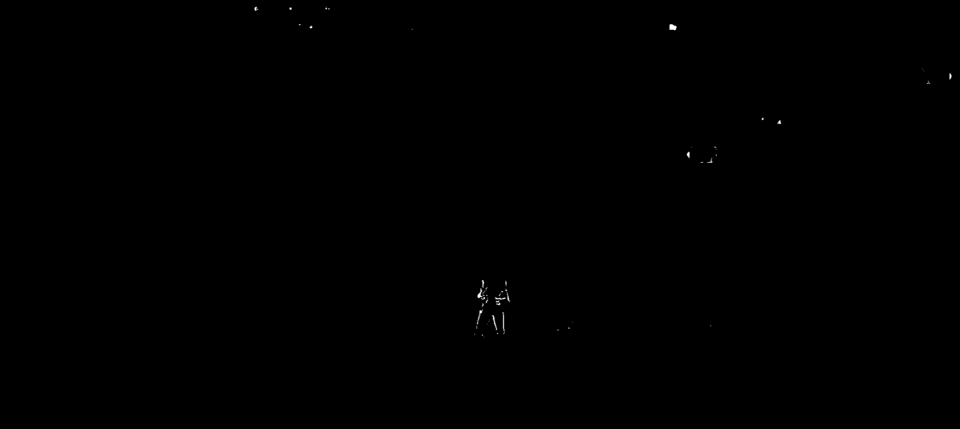

In [71]:
# Convert mask to grayscale image for morphological operations
mask_gray = Gray.(mask)

In [72]:
se = centered(Bool[
    0 0 1 1 1 0 0
    0 1 1 1 1 1 0
    1 1 1 1 1 1 1
    1 1 1 1 1 1 1
    1 1 1 1 1 1 1
    0 1 1 1 1 1 0
    0 0 1 1 1 0 0
])

se2 = centered(Bool[
    0 0 1 0 0  
    0 1 1 1 0  
    1 1 1 1 1  
    0 1 1 1 0 
    0 0 1 0 0 
])

5×5 OffsetArray(::Matrix{Bool}, -2:2, -2:2) with eltype Bool with indices -2:2×-2:2:
 0  0  1  0  0
 0  1  1  1  0
 1  1  1  1  1
 0  1  1  1  0
 0  0  1  0  0

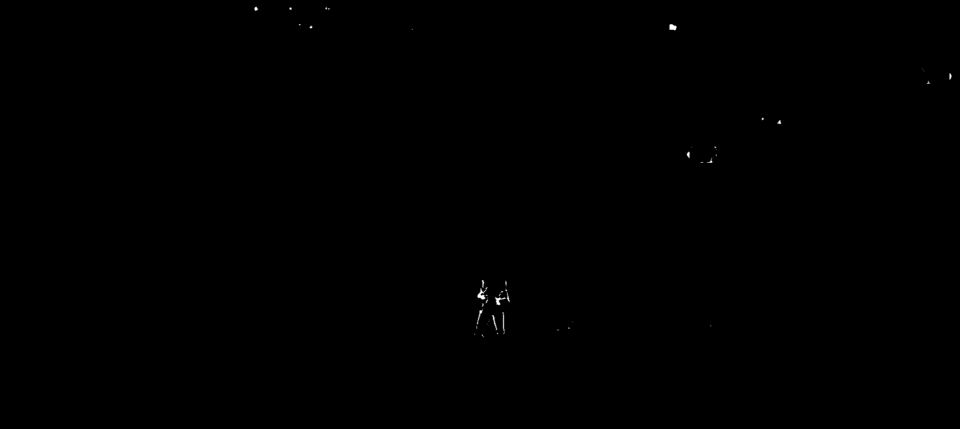

In [73]:
#img_erode = @. Gray(mask_gray < 0.1); # keeps white objects white
img_erosion1 = closing(mask_gray,se2)

In [74]:

function bounding_boxes(mask::Array{T, 2}) where {T}
    # Encontrar los objetos en la máscara binaria
    objects = label_components(mask)
    
    # Inicializar un vector para almacenar los bounding boxes de cada objeto
    bounding_boxes_list = Tuple[]
    
    # Iterar sobre cada objeto y calcular su bounding box
    for obj in 1:maximum(objects)
        # Crear una máscara para el objeto actual
        obj_mask = objects .== obj
        
        # Encontrar los índices de los píxeles no negros en la máscara del objeto
        non_black_pixels = findall(!isequal(zero(T)), obj_mask)
        
        # Calcular coordenadas mínimas y máximas de los píxeles no negros
        min_x = minimum(i[2] for i in non_black_pixels)
        max_x = maximum(i[2] for i in non_black_pixels)
        min_y = minimum(i[1] for i in non_black_pixels)
        max_y = maximum(i[1] for i in non_black_pixels)
        
        # Agregar el bounding box a la lista
        push!(bounding_boxes_list, (min_x, min_y, max_x, max_y))
    end
    
    # Devolver la lista de bounding boxes
    return bounding_boxes_list
end

bounding_boxes (generic function with 1 method)

In [75]:
bbox = bounding_boxes(img_erosion1)


63-element Vector{Tuple}:
 (509, 14, 515, 21)
 (579, 15, 582, 19)
 (598, 49, 600, 50)
 (619, 52, 624, 56)
 (651, 15, 653, 18)
 (653, 14, 653, 14)
 (656, 17, 658, 19)
 (824, 58, 824, 59)
 (949, 668, 949, 669)
 (953, 652, 953, 657)
 ⋮
 (1432, 299, 1432, 299)
 (1432, 309, 1432, 312)
 (1523, 236, 1526, 240)
 (1555, 241, 1561, 248)
 (1845, 138, 1845, 138)
 (1847, 142, 1847, 142)
 (1854, 164, 1859, 167)
 (1856, 162, 1856, 163)
 (1899, 147, 1902, 159)

In [76]:
function merge_close_bounding_boxes(bounding_boxes_list::Vector{T}, threshold::Real) where T<:Tuple
    # Creamos una copia de la lista original de bounding boxes para no modificarla directamente
    merged_boxes = deepcopy(bounding_boxes_list)
    
    # Bandera para indicar si se han realizado fusiones
    merged = true
    
    # Iteramos hasta que no haya más fusiones
    while merged
        merged = false
        
        # Iteramos sobre cada par de bounding boxes
        for i in 1:length(merged_boxes)-1
            for j in i+1:length(merged_boxes)
                box1 = merged_boxes[i]
                box2 = merged_boxes[j]
                
                # Calculamos la distancia entre los centros de las bounding boxes
                center1 = ((box1[1] + box1[3]) / 2, (box1[2] + box1[4]) / 2)
                center2 = ((box2[1] + box2[3]) / 2, (box2[2] + box2[4]) / 2)
                distance = sqrt((center1[1] - center2[1])^2 + (center1[2] - center2[2])^2)
                
                # Si la distancia es menor que el umbral, fusionamos las bounding boxes
                if distance < threshold
                    merged_boxes[i] = (min(box1[1], box2[1]), min(box1[2], box2[2]), max(box1[3], box2[3]), max(box1[4], box2[4]))
                    deleteat!(merged_boxes, j)
                    merged = true
                    break
                end
            end
            
            if merged
                break
            end
        end
    end
    
    return merged_boxes
end


merge_close_bounding_boxes (generic function with 1 method)

In [77]:
function print_merged_bounding_boxes(merged_boxes::Vector{T}) where T<:Tuple
    for (i, bbox) in enumerate(merged_boxes)
        println("Bounding Box $i: ", bbox)
    end
end


print_merged_bounding_boxes (generic function with 1 method)

In [78]:
# Definir umbral de proximidad para la fusión de bounding boxes (ajusta este valor según tus necesidades)
threshold = 200  # Por ejemplo

# Fusionar las bounding boxes cercanas
merged_boxes = merge_close_bounding_boxes(bbox, threshold)

# Imprimir las bounding boxes fusionadas
print_merged_bounding_boxes(merged_boxes)

Bounding Box 1: (509, 14, 658, 56)
Bounding Box 2: (824, 58, 824, 59)
Bounding Box 3: (949, 561, 1145, 674)
Bounding Box 4: (1339, 49, 1352, 60)
Bounding Box 5: (1374, 236, 1561, 325)
Bounding Box 6: (1421, 651, 1421, 652)
Bounding Box 7: (1845, 138, 1902, 167)
